## Overview

To make it easier for everyone to access the large (50+ GB) data in bite-sized chunks, I have written a script called repackage_data.py (under dustcurve/) which inputs a healpy nside 128 index and outputs a repackaged data file called index.h5, containing all the stellar posterior, stellar coordinate, and CO intensity data for that index. A healpy nside 128 pixel index essentially identifies a unique 0.4 sq. deg. chunk of area on the sky, so when you input the index, you're outputting all the relevant information needed to run the MCMC code on that specific area of the sky. All the mini-area files will eventually be made available on a public Odyssey server, so users will be able to retrieve only as much data as they need. 

For the purposes of this tutorial, I used repackage_data.py to create a data file called "89996.h5" which contains 3000+ stars for a 0.4 sq. deg. chunk of area, centered right in the middle of our cloud of interest, the Cepheus molecular cloud, located at (Galactic longitude, Galactic latitude)=$(l,b)$=$(109.7 ^\circ, 13.7 ^\circ)$. While we would like to eventually run the script on the entire area covering Cepheus (approximately 3x3 deg), we are going to pick a small section constituting the most important chunk of the cloud.  

This tutorial will closely mimic the analysis done in model.ipynb, except now we're using real data and we're trying to estimate the values of d1-12, not just d7 and d11. Despite the fact that we're only using a subset of the data, our values for d1-12 should still hover around the kinematic distance to the Cepheus molecular cloud given by the literature (distance modulus $\mu=9.3$). The velocity gradient is so small over this region that kinematic distances place the entire cloud at approximately this distance modulus. However, we know that kinematic distances for local clouds like Cepheus tend to be unreliable. This is because the local clouds are orbiting the Galactic center at almost the same angular velocity as the sun, so they are dominated by large peculiar velocities with respect to the Sun. So we are going to set off walkers for all the slices at $\mu=9.3$, but we shouldn't be surprised if they wander a bit. 

For reference, this is what the stacked stellar posterior array looks like for our region of interest, where the x and y axes show bin number. A $\mu=9.3$ corresponds to a bin index of 42. 

<img src="posterior_sum_89996.png">


## Logistics

We are going to use parallel-tempering, implemented via the python emcee package, to explore our posterior, which consists of the set of distances to the twelve velocity slices. Since we need to explore a twelve dimensional parameter space, we are going to use 50 walkers, 500 steps each, at 5 different temperatures. However, we are only going to keep the lowest temperature chain ($\beta=1$) for analysis. For more information on how PTSampler works, see http://dan.iel.fm/emcee/current/user/pt/. Once again, we will set off our walkers in a ball around the kinematic distance estimates for the Cepheus molecular cloud ($\mu=9.3$). You can edit the starting positions of the walkers by editing the "result" variable below. 

### Setting up the positional arguments for PTSampler

We need to feed PTSampler the required positional arguments for the log_likelihood and log_prior function. We do this using the fetch_args function from the io module, which creates an instance of the pixclass object that holds our data and metadata. Fetch_args accepts three arguments: 

- A string specifiying the h5 filename containing your data, in our case 89996.h5
- The prior bounds you want to impose on the distances (flat prior), in units of distance modulus. This is given as a list in the format [lowerbound, upperbound]. This must be between 4 and 19, because that's the distance modulus range of our stellar posterior array. For this problem, we restrict our distances to the region where we see the bulk of the probability in the stacked stellar posterior (i.e. bins 20-90, or $\mu$=6.5 to 15.25.
- The gas-to-dust coefficient you'd like to use, given as a float; for this tutorial, we are pulling a value from the literature of 0.03 magnitudes/K. 

Fetch_args will then return the correct arguments for the log_likelihood and log_prior functions within the model module. 

Here we go!

In [1]:
import emcee
from dustcurve import model
import seaborn as sns
import numpy as np
from dustcurve import pixclass
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from dustcurve import io
%matplotlib inline

#suppress obnoxious deprecation warning that doesn't affect output
warnings.filterwarnings("ignore", category=Warning, module="emcee")

#fetch the required likelihood and prior arguments for PTSampler
ldata,pdata=io.fetch_args('89996.h5',[6.5,15.25],0.03)

# the model has 12 parameters; we'll use 50 walkers, 500 steps each, at 5 different temps
ndim=12
nwalkers = 50
nsteps = 500
ntemps=5

#we are setting off the walkers at the kinematic distance given by the literature
result=[9.3 for i in range(ndim)]

#slightly perturb the starting positions for each walker, in a ball centered around result
starting_positions = [[result + 1e-1*np.random.randn(ndim) for i in range(nwalkers)] for j in range(ntemps)]

#set up the sampler object
sampler = emcee.PTSampler(ntemps, nwalkers, ndim, model.log_likelihood, model.log_prior, loglargs=(ldata), logpargs=[pdata])

# run the sampler and time how long it takes
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')



CPU times: user 14h 38min 35s, sys: 1min 54s, total: 14h 40min 30s
Wall time: 14h 39min 55s
Done


The sampler is done running, so now let's check out the results. We are going to print out our mean acceptance fraction across all walkers for the coldest temperature chain. 

We are going to discard the first 500 steps of each chain as burn-off. Then we are going to plot what the chains look like, for each distance parameter and for the first ten walkers. The chains should all be reasonably well-mixed. Finally, we are going to compute and print out the 50th, 16th, and 84th percentile of chain for each distance parameter. The 50th percentile measurement represents are best guess for the each distance parameter, while the 16th and 84th percentile parameter give us a sense of the uncertainty. 

Our mean acceptance fraction for the coldest chain is 0.09
d1= 8.41 + 0.16 - 0.43
d2= 8.26 + 0.37 - 0.52
d3= 7.71 + 0.73 - 0.24
d4= 9.18 + 0.08 - 0.48
d5= 7.65 + 0.33 - 0.26
d6= 7.84 + 0.27 - 0.24
d7= 8.69 + 0.40 - 0.58
d8= 8.46 + 0.26 - 0.98
d9= 9.87 + 0.75 - 0.10
d10= 8.06 + 0.53 - 0.66
d11= 9.10 + 2.11 - 0.26
d12= 9.26 + 0.10 - 0.84


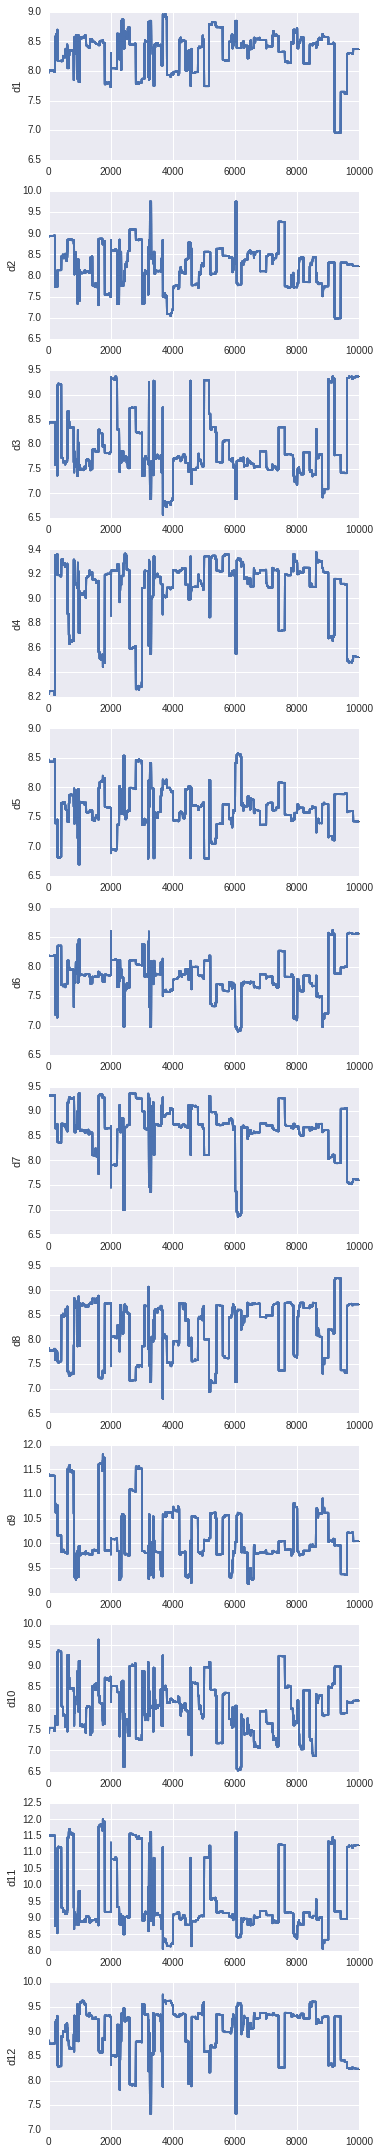

In [3]:
#check out acceptance fraction:
print("Our mean acceptance fraction for the coldest chain is %.2f" % np.mean(sampler.acceptance_fraction[0]))

#discard the first 300 steps as burn-off and resshape the array
samples_cold = sampler.chain[0,:,300:,:]
traces_cold = samples_cold.reshape(-1, ndim).T
    
#set up subplots for chain plotting
fig, (ax_d1, ax_d2, ax_d3, ax_d4, ax_d5, ax_d6, ax_d7, ax_d8, ax_d9, ax_d10, ax_d11, ax_d12) = plt.subplots(12, figsize=(5,30))

plt.tight_layout()

#label axes
ax_d1.set(ylabel='d1')
ax_d2.set(ylabel='d2')
ax_d3.set(ylabel='d3')
ax_d4.set(ylabel='d4')
ax_d5.set(ylabel='d5')
ax_d6.set(ylabel='d6')
ax_d7.set(ylabel='d7')
ax_d8.set(ylabel='d8')
ax_d9.set(ylabel='d9')
ax_d10.set(ylabel='d10')
ax_d11.set(ylabel='d11')
ax_d12.set(ylabel='d12')

#plot chains for each parameter, for first 10 walkers
for i in range(10):
    sns.tsplot(traces_cold[0], ax=ax_d1)
    sns.tsplot(traces_cold[1], ax=ax_d2)
    sns.tsplot(traces_cold[2], ax=ax_d3)
    sns.tsplot(traces_cold[3], ax=ax_d4)
    sns.tsplot(traces_cold[4], ax=ax_d5)
    sns.tsplot(traces_cold[5], ax=ax_d6)
    sns.tsplot(traces_cold[6], ax=ax_d7)
    sns.tsplot(traces_cold[7], ax=ax_d8)
    sns.tsplot(traces_cold[8], ax=ax_d9)
    sns.tsplot(traces_cold[9], ax=ax_d10)
    sns.tsplot(traces_cold[10], ax=ax_d11)
    sns.tsplot(traces_cold[11], ax=ax_d12)

    
#store the chain information
parameter_samples = pd.DataFrame({'d1': traces_cold[0], 'd2': traces_cold[1], 'd3': traces_cold[2], 
                                  'd4': traces_cold[3], 'd5': traces_cold[4], 'd6': traces_cold[5],
                                  'd7': traces_cold[6], 'd8': traces_cold[7], 'd9': traces_cold[8],
                                  'd10': traces_cold[9], 'd11': traces_cold[10], 'd12': traces_cold[11]})

q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

#what values do we get?
for i in range(1,13):
    print("d"+str(i)+"= {:.2f} + {:.2f} - {:.2f}".format(q["d"+str(i)][0.50], 
                                                q["d"+str(i)][0.84]-q["d"+str(i)][0.50],
                                                q["d"+str(i)][0.50]-q["d"+str(i)][0.16]))

We see that our cloud appears to be broken up into several distance components, spanning from $\mu =7.71-9.87$ or 348-941 pc. While this is generally inconsistent with the kinematic distance method, it is more consistant with existing dust-based photometric distance estimates from Schlafly et al. 2014. See "DustCurve Final Paper" with the root directory of dustcurve for more in-depth analysis of these results!  